In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd

#查看tf 和 keras 的版本
print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


In [2]:
# 从 keras.datasets 里面 加载 fashion_mnist 的数据集（很多种类的黑白图片）
fashion_mnist = keras.datasets.fashion_mnist

#拆分训练集和测试集
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

#把训练集拆分成 训练集和验证集   验证集取前5000个数据， 训练集取5000以后的数据
x_vaild, x_train = x_train_all[:5000], x_train_all[5000:]
y_vaild, y_train = y_train_all[:5000], y_train_all[5000:]

#打印 训练集、验证集、测试集的格式    （通过结果可以发现，验证集有5000个28*28的numpy数组，像素位在0~255 的数据，训练集有55000个，测试集有10000个）
print(x_vaild.shape, y_vaild.shape)
print(x_train.shape, y_train.shape) 
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
#进行数据归一化   # x =  (x-u) / std   u:均值   std:方差    --> 使用fit_transform方法实现
import sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

x_vaild_scaled = scaler.transform(x_vaild.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [4]:
#tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation = "relu"))
    # 实现bn (批归一化)  放在激活函数之后
    model.add(keras.layers.BatchNormalization())
    """
    #批归一化放在激活函数之前
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
     
    """
   
model.add(keras.layers.Dense(10, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy",  
               optimizer = "SGD", #优化器
               metrics = ["accuracy"])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

In [6]:
#使用fit方法进行训练模型，  epoches为训练次数， 结果中loss为待减少的损失值， accuracy为准确率, 验证准确率使用的数据集为x_vaild

#tensorBoard, earlystopping, ModelCheckpoint
#tensorBoard需要的是一个文件夹，  ModelCheckpoint需要的是该文件夹里的文件名
#earlyStopping 是 一个触发式函数， patience: 没有进步的训练轮数，在这之后训练就会被停止。 被检测的数据monitor参数默认值为 loss值，
#                                  min_delta: 在被监测的数据中被认为是提升的最小变化， 例如，小于 min_delta 的绝对变化会被认为没有提升。

logdir = '.\dnn-bn-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,'fashion_mnist_model.h5')
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-3),
    
    
]

history = model.fit(x_train_scaled, y_train, epochs = 10, 
         validation_data = (x_vaild_scaled, y_vaild),
          callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 14s 259us/sample - loss: 1.0361 - accuracy: 0.6333 - val_loss: 0.6276 - val_accuracy: 0.7812
Epoch 2/10
55000/55000 [==============================] - 10s 189us/sample - loss: 0.7321 - accuracy: 0.7417 - val_loss: 0.5170 - val_accuracy: 0.8108
Epoch 3/10
55000/55000 [==============================] - 10s 187us/sample - loss: 0.6361 - accuracy: 0.7779 - val_loss: 0.4770 - val_accuracy: 0.8254
Epoch 4/10
55000/55000 [==============================] - 10s 187us/sample - loss: 0.5812 - accuracy: 0.7958 - val_loss: 0.4363 - val_accuracy: 0.8406
Epoch 5/10
55000/55000 [==============================] - 10s 187us/sample - loss: 0.5461 - accuracy: 0.8081 - val_loss: 0.4269 - val_accuracy: 0.8448
Epoch 6/10
55000/55000 [==============================] - 10s 188us/sample - loss: 0.5122 - accuracy: 0.8226 - val_loss: 0.4049 - val_accuracy: 0.8552
Epoch 7/10
55000/55000 [=====================

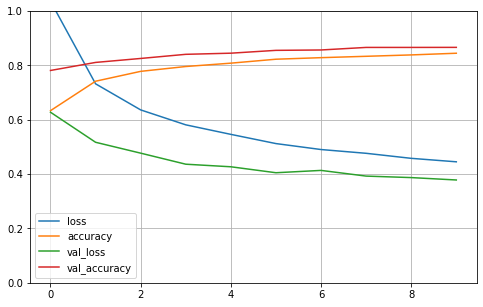

In [8]:
def plot_leaning_curves(history):
    pd.DataFrame(history.history).plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_leaning_curves(history)

In [9]:
#使用model.evaluate() 方法来验证测试集的准确率
test_loss , test_acc = model.evaluate(x_test_scaled, y_test) 
print("   test_acc:",test_acc)

10000/10000 [==============================] - 1s 65us/sample - loss: 0.4063 - accuracy: 0.8561
   test_acc: 0.8561
